In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

2024-04-09 14:13:28.463370: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 14:13:28.633074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 14:13:28.633156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 14:13:28.633176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 14:13:28.718170: I tensorflow/core/platform/cpu_feature_g

58889256/58889256 [==============================] - 8s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = '/home/shidaohg/WorkPlace/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0

    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


2024-04-09 14:19:07.371297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-09 14:19:07.579042: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 11ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 13ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 11ms/step


In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30


2024-04-09 14:21:48.079413: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-09 14:21:48.749871: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x712438e21d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-09 14:21:48.749899: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-04-09 14:21:48.766597: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 14:21:48.873060: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 2s 3ms/step - loss: 0.6345 - acc: 0.7585 - val_loss: 0.2894 - val_acc: 0.8780
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3527 - acc: 0.8500 - val_loss: 0.4761 - val_acc: 0.8070
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2828 - acc: 0.8800 - val_loss: 0.2491 - val_acc: 0.8970
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2262 - acc: 0.9025 - val_loss: 0.2826 - val_acc: 0.8940
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2126 - acc: 0.9125 - val_loss: 0.2957 - val_acc: 0.8730
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.1799 - acc: 0.9240 - val_loss: 0.3815 - val_acc: 0.8650
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.1672 - acc: 0.9345 - val_loss: 0.3572 - val_acc: 0.8790
Epoch 8/30
100/100 [==============================] - 0s 1ms/step - loss: 0.1498 - acc:

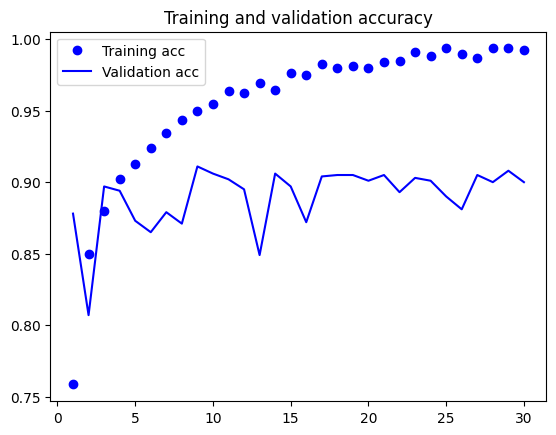

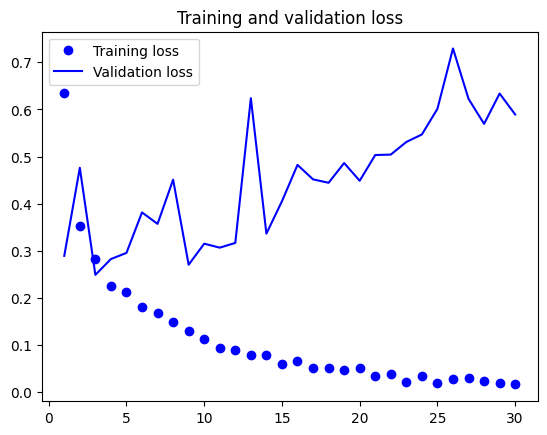

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
max(val_acc)

0.9110000133514404